In [ ]:
!unzip '/content/drive/My Drive/Projects/Cats and dogs classifier/Data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Data/Train/training/19519.jpg  
  inflating: Data/Train/training/cat.3882.jpg  
  inflating: Data/Train/training/dog.2.jpg  
  inflating: Data/Train/training/11560.jpg  
  inflating: Data/Train/training/15462.jpg  
  inflating: Data/Train/training/11541.jpg  
  inflating: Data/Train/training/13658.jpg  
  inflating: Data/Train/training/dog.782.jpg  
  inflating: Data/Train/training/cat.3224.jpg  
  inflating: Data/Train/training/15449.jpg  
  inflating: Data/Train/training/10892.jpg  
  inflating: Data/Train/training/dog.3442.jpg  
  inflating: Data/Train/training/cat.1224.jpg  
  inflating: Data/Train/training/cat.418.jpg  
  inflating: Data/Train/training/dog.284.jpg  
  inflating: Data/Train/training/9798.jpg  
  inflating: Data/Train/training/dog.2321.jpg  
  inflating: Data/Train/training/16504.jpg  
  inflating: Data/Train/training/cat.2380.jpg  
  inflating: Data/Train/training/dog.3853.jpg  
  inflating: Data/Train

In [ ]:
# FOR TPU

!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4994  100  4994    0     0  80548      0 --:--:-- --:--:-- --:--:-- 81868
Updating... This may take around 2 minutes.
Updating TPU runtime to pytorch-nightly ...
     |████████████████████████████████| 61kB 2.9MB/s 
Uninstalling torch-1.5.1+cu101:
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12
Done updating TPU runtime
  Successfully uninstalled torch-1.5.1+cu101
Uninstalling torchvision-0.6.1+cu101:
  Successfully uninstalled torchvision-0.6.1+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly-cp36-cp36m-linux_x86_64.whl...
- [1 files][107.7 MiB/107.7 MiB]                                                
Operation completed over 1 objects/107.7 MiB.                                    
Copying gs://

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
from torchvision import models
import torch.optim as optim
import pandas as pd
import numpy as np
import cv2
import os
from sklearn import preprocessing
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [ ]:
%%capture
! pip install git+https://github.com/PytorchLightning/pytorch-lightning.git@master --upgrade

In [ ]:
data = pd.read_csv('/content/Data/Train_new.csv')
test = pd.read_csv('/content/Data/Sample_Submission.csv')

In [ ]:
data.head()

,images,labels
0,dog.3069.jpg,1
1,cat.734.jpg,0
2,dog.1594.jpg,1
3,dog.3770.jpg,1
4,dog.2733.jpg,1


In [ ]:
test.head()

,File_Name,Category
0,8121.jpg,1
1,15486.jpg,1
2,8132.jpg,1
3,16297.jpg,1
4,20838.jpg,1


In [ ]:
class DanceData(Dataset):
    def __init__(self,data_list,transform_tensor, data_dir = './',transform_image=None, train=True, target=None):
        super().__init__()
        self.data_list = data_list
        self.data_dir = data_dir
        self.transform_image = transform_image
        self.transform_tensor = transform_tensor
        self.train = train
        self.target = target
    
    def __len__(self):
        return self.data_list.shape[0]
    
    def __getitem__(self,item):
        if self.train:
          img_name,label = self.data_list.iloc[item]
          label = self.target[item]
        else:
          img_name = self.data_list.iloc[item]['images']
        img_path = os.path.join(self.data_dir,img_name)
        img = cv2.imread(img_path,1)
        # img = cv2.resize(img, (224,224))
        # img = img/255
        if self.transform_image is not None:
            img = self.transform_image(img)

        else:
          img = cv2.resize(img, (224,224))
        img = np.array(img)/255

        img = self.transform_tensor(img)

        
        if self.train:
          return {
              'gt' : img,
              'label' : torch.tensor(label)

          }
        else:
          return {
              'gt':img
          }

In [ ]:
from sklearn.preprocessing import OneHotEncoder
one = OneHotEncoder()

targets = one.fit_transform(np.array(data['labels']).reshape(-1,1)).todense()

In [ ]:
ntrain = data.copy()

In [ ]:
targets = pd.DataFrame(targets).values

In [ ]:
from sklearn.model_selection import train_test_split

train_images,val_images, train_target, val_target = train_test_split(data, targets, test_size = 0.1, random_state = 123)

In [ ]:
transforms_image = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(10)
    ])


transforms_image_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224)
    ])


transforms_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize( mean = np.array([0.485, 0.456, 0.406]),
    std = np.array([0.229, 0.224, 0.225]))
])
train_path = '/content/Data/Train/training'
test_path = '/content/Data/Test'

train_data = DanceData(data_list= train_images,data_dir = train_path, transform_tensor=transforms_tensor,transform_image = transforms_image, target = train_target)
val_data = DanceData(data_list= val_images,data_dir = train_path, transform_tensor=transforms_tensor,transform_image = transforms_image_val, target = val_target)
test_data= DanceData(data_list= test,data_dir = test_path, transform_tensor=transforms_tensor,transform_image = transforms_image_val, target = test['Category'])

In [ ]:
batch = 16
batch_val = 4
# valid_size = 0.3
# num = train_data.__len__()
# # Dividing the indices for train and cross validation
# indices = list(range(num))
# np.random.shuffle(indices)
# split = int(np.floor(valid_size*num))
# train_idx,valid_idx = indices[split:], indices[:split]

# #Create Samplers
# train_sampler = SubsetRandomSampler(train_idx)
# valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size = batch, shuffle = True)
valid_loader = DataLoader(val_data, batch_size = batch_val, shuffle = False)
test_loader = DataLoader(test_data, batch_size = 1, shuffle = False)

In [ ]:
import torch_xla as xla
import torch_xla.core.xla_model as xm

In [ ]:
# device=xm.xla_device()

In [ ]:
import pytorch_lightning as pl

class Network(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.feature_extractor = models.resnet34(pretrained=True)
        # Resnet as fixed Feature Extractor
        # for param in self.feature_extractor.parameters():
        #     param.requires_grad = False
        # self.feature_extractor.fc = nn.Sequential(nn.Linear(self.feature_extractor.fc.in_features,1024), nn.LeakyReLU(inplace=True), 
        #                                           nn.Linear(1024,1024), nn.LeakyReLU(inplace=True), nn.Linear(1024,512), nn.LeakyReLU(inplace=True), 
        #                                           nn.Linear(512,256), nn.LeakyReLU(inplace=True), nn.Linear(256,2))
        # Fine Tuning Resnet
        self.feature_extractor.classifier = nn.Linear(self.feature_extractor.classifier.in_features,2)
    def forward(self, x):
      # Forward pass
        x = self.feature_extractor(x)
        #x = F.softmax(x)
        return x
    
    # def train_dataloader(self):
    #     return DataLoader(train_data, batch_size = batch, shuffle = True, num_workers = 4)

    def configure_optimizers(self):
        optimizer = torch.optim.RMSprop(self.parameters(), lr=1e-4)
        schedular = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 3, factor = 0.1)
        return [optimizer], [schedular]
    
    # def configure_optimizers(self):
    #     return torch.optim.Adam(self.parameters(), lr=1e-4)
    
    
    def training_step(self, batch, batch_idx):
        data = batch['gt']
        target = batch['label']
        logits = self(data)
        loss = F.binary_cross_entropy_with_logits(logits, target)
        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}
    
    # def training_epoch_end(self, outputs):
    #     avg_train_loss = torch.stack([x['train_loss'] for x in outputs]).mean()
    #     train_logs = {'train_loss': avg_train_loss}
    #     return {'avg_train_loss':avg_train_loss, 'log':train_logs}
    
    def validation_step(self, batch, batch_idx):
        data = batch['gt']
        target = batch['label']
        logits = self(data)
        loss = F.binary_cross_entropy_with_logits(logits, target)
        return {'val_loss': loss}
    
    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        val_logs = {'val_loss': avg_val_loss}
        return {'avg_val_loss':avg_val_loss, 'log':val_logs}
    
    # def val_dataloader(self):
    #     return DataLoader(val_data, batch_size = batch_val, shuffle = False, num_workers = 4)

In [ ]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # Assuming that we are on a CUDA machine, this should print a CUDA device:

# print(device)    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type   | Params
---------------------------------------------
0 | feature_extractor | ResNet | 21 M  


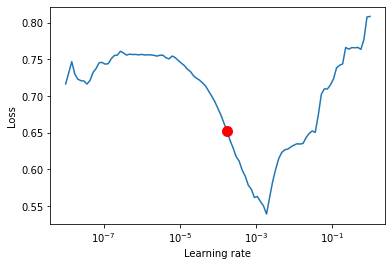

In [ ]:
# Run learning rate finder
from pytorch_lightning import Trainer, seed_everything
seed_everything(0)
model = Network()
trainer = Trainer(gpus = 1)
lr_finder = trainer.lr_find(model, train_loader, valid_loader)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
from pytorch_lightning import Trainer, seed_everything

seed_everything(0)

# from pytorch_lightning.loggers.neptune import NeptuneLogger
from pytorch_lightning.callbacks import EarlyStopping


model = Network()
# neptune_logger = NeptuneLogger(
#     api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiN2Q5MmEzMDMtNmQzYS00MTdiLTg5YTgtN2I2MGFmMThkODE1In0=",
#     project_name="devesh2707/sandbox",
#     experiment_name="Orientime",
#     close_after_fit=False
# )
# early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3)
trainer = Trainer(num_tpu_cores=8, max_epochs=3)
trainer.fit(model, train_loader, valid_loader)   

GPU available: False, used: False
TPU available: True, using: 8 TPU cores
training on 8 TPU cores
INIT TPU local core: 0, global rank: 0
INIT TPU local core: 7, global rank: 7
INIT TPU local core: 1, global rank: 1
INIT TPU local core: 5, global rank: 5
INIT TPU local core: 3, global rank: 3
INIT TPU local core: 4, global rank: 4
INIT TPU local core: 2, global rank: 2
INIT TPU local core: 6, global rank: 6

  | Name              | Type     | Params
-----------------------------------------------
0 | feature_extractor | DenseNet | 6 M   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: cleaning up... please do not interrupt
  warnings.warn(*args, **kwargs)


1

In [ ]:
validation_loader = DataLoader(val_data, batch_size = 1, shuffle = False)

In [ ]:
x = next(iter(validation_loader))['gt']

In [ ]:
x

tensor([[[[-1.0562, -1.0562, -1.0562,  ..., -0.9877, -1.0048, -1.0219],
          [-1.0562, -1.0562, -1.0562,  ..., -0.9877, -1.0048, -1.0219],
          [-1.0048, -1.0048, -1.0048,  ..., -0.9877, -1.0048, -1.0048],
          ...,
          [-0.9192, -0.9192, -0.9363,  ..., -1.1247, -1.1760, -1.1932],
          [-1.0219, -1.0219, -1.0390,  ..., -1.1589, -1.1932, -1.2274],
          [-1.0904, -1.0904, -1.1075,  ..., -1.1589, -1.2103, -1.2274]],

         [[-0.8627, -0.8627, -0.8627,  ..., -0.7577, -0.7752, -0.7927],
          [-0.8627, -0.8627, -0.8627,  ..., -0.7577, -0.7752, -0.7927],
          [-0.8452, -0.8452, -0.8452,  ..., -0.7577, -0.7752, -0.7752],
          ...,
          [-1.5280, -1.5280, -1.5280,  ..., -1.4230, -1.4755, -1.4930],
          [-1.6155, -1.5980, -1.6155,  ..., -1.4580, -1.4930, -1.5280],
          [-1.6681, -1.6681, -1.6681,  ..., -1.4580, -1.5105, -1.5280]],

         [[-0.2707, -0.2707, -0.2707,  ..., -0.2358, -0.2532, -0.2707],
          [-0.2707, -0.2707, -

In [ ]:
device=xm.xla_device()

In [ ]:
%env XLA_USE_BF16=0

env: XLA_USE_BF16=0


In [ ]:
print(devices)

['xla:1', 'xla:2', 'xla:3', 'xla:4', 'xla:5', 'xla:6', 'xla:7', 'xla:8']


In [ ]:
print(device)

xla:1


In [ ]:
model = model.to(device)

In [ ]:
x.to(device)

tensor([[[[-1.0562, -1.0562, -1.0562,  ..., -0.9877, -1.0048, -1.0219],
          [-1.0562, -1.0562, -1.0562,  ..., -0.9877, -1.0048, -1.0219],
          [-1.0048, -1.0048, -1.0048,  ..., -0.9877, -1.0048, -1.0048],
          ...,
          [-0.9192, -0.9192, -0.9363,  ..., -1.1247, -1.1760, -1.1932],
          [-1.0219, -1.0219, -1.0390,  ..., -1.1589, -1.1932, -1.2274],
          [-1.0904, -1.0904, -1.1075,  ..., -1.1589, -1.2103, -1.2274]],

         [[-0.8627, -0.8627, -0.8627,  ..., -0.7577, -0.7752, -0.7927],
          [-0.8627, -0.8627, -0.8627,  ..., -0.7577, -0.7752, -0.7927],
          [-0.8452, -0.8452, -0.8452,  ..., -0.7577, -0.7752, -0.7752],
          ...,
          [-1.5280, -1.5280, -1.5280,  ..., -1.4230, -1.4755, -1.4930],
          [-1.6155, -1.5980, -1.6155,  ..., -1.4580, -1.4930, -1.5280],
          [-1.6681, -1.6681, -1.6681,  ..., -1.4580, -1.5105, -1.5280]],

         [[-0.2707, -0.2707, -0.2707,  ..., -0.2358, -0.2532, -0.2707],
          [-0.2707, -0.2707, -

In [ ]:
model(x.to(device))

tensor([[ 0.2912, -0.1450]], device='xla:1', dtype=torch.float64,
       grad_fn=<AddmmBackward>)

In [ ]:
model.eval()
preds = []
with torch.no_grad():
    for batch in validation_loader:
        data = batch['gt'].to(device)
        outputs = model(data)
        pred = int(outputs.cpu().argmax())
        preds.append(pred)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

print('Accuracy: {}'.format(accuracy_score(val_target[:,1:], preds)))

Accuracy: 0.9931350114416476


In [ ]:
val_target[:,1:]

array([[0.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [ ]:
val_target

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
model.eval()
preds = []
with torch.no_grad():
    for batch in test_loader:
        data = batch['gt'].to(device)
        outputs = model(data)
        pred = int(outputs.cpu().argmax())
        preds.append(pred)

In [ ]:
test['Category'] = preds

In [ ]:
test.to_csv('resnet_34_secind.csv', index = False)